# Método metrópolis para múltiple puebas aleatorias

In [1]:
 #%reset

In [2]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
import pickle
import matplotlib.colors as mcolors

In [3]:
data = np.load('fit_exercise.npy') 
#data

x = data[0,:]      #primer renglón
#print(x)
x_avrg = x.mean
y = data[1,:]      #segundo renglón
y_err = data[2,:]  #tercer renglón
n = len(x)

In [4]:
"""definimos la función con la que aproximaremos nuestro likelihood, en este caso es una func. lineal"""

def f(x,pendiente,cte):
    f = pendiente*x + cte
    return f

"""definimos una función para el likelihood"""
def LogLikelihood(x,pendiente,cte,y,DesviacionEstandar):
    LogL=0
    n = len(x)
    for i in range(n):
        LogL = LogL - ((y[i] - f(x[i],pendiente,cte))**2)/(2*((DesviacionEstandar[i])**2)) -(n/2)*np.log(2*np.pi*(DesviacionEstandar[i])**2)
    return LogL


In [5]:
"""Vamos a definir una función en la que nosotros vamos a definir la probabilidad de encontrar nuestros
datos en un intervalo específico (en base l plot de x vs y)"""

"""La probabilidad (Prior de m) de encontrar a m en cierto intervalo"""

def Prior_m(pendiente):
    m_min = -20
    m_max = 20
    if m_min<= pendiente and pendiente<= m_max:
        Pm = 1/(m_max-m_min)
    else:
        Pm = 0
    return Pm

"""La probabilidad (Prior de b) de encontrar a b en cierto intervalo""" 

def Prior_b(cte):
    b_min = -20
    b_max = 20
    if b_min<= cte and cte <= b_max:
        Pb = 1/(b_max-b_min)
    else:
        Pb = 0
    return Pb

In [6]:
#definimos el posterior (la prob. de que nuestrosdatos sean correctos)
def Post(m_n,b_n,x,y,sigma):
    LogPos = np.log(Prior_m(m_n)) + np.log(Prior_b(b_n)) + (LogLikelihood(x,m_n,b_n,y,sigma))
    return LogPos

# Def múltiples Metropolis

In [7]:
def metropolis(n_pasos,m_v,b_v,x,y,y_err):

    Post_v = Post(m_v,b_v,x,y,y_err) #posterior

    mb = np.zeros([n_pasos + 1,2]) #contiene a TODOS los m y b
    mb[0] = [m_v,b_v]

    #aquí solo escribiremos los que sí pasen el filtro de metrópolis
    m_acep = []
    b_acep = []

    counting = 0
    
    for i in range(1,n_pasos):
        m_rnd = np.random.normal(m_v,0.2)  #m aleatorios
        b_rnd = np.random.normal(b_v,0.2)  #b aleatorios
    
        m_n = m_rnd  #aquí guardamos moentáneamente 'm'
        b_n = b_rnd #aquí guardamos moentáneamente 'b'
    
        Post_n = Post(m_n,b_n,x,y,y_err)
        #print(Post_n)
        mb[i+1] = [m_n,b_n]
    
        if Post_n > Post_v: #comparamos si el likelihood nuevo es mayor al viejo
        
            """Reevaluamos los valores de nuestras constantes"""
        
            Post_v = np.copy(Post_n)
            m_v = np.copy(m_n)
            b_v = np.copy(b_n)
            #print('nuevo Posterior viejo',Post_v)
            #counting = counting+1
            m_acep.append(m_v)
            b_acep.append(b_v)
        
        
        
        elif Post_n - Post_v > np.random.rand():
            Post_v = np.copy(Post_n)
            m_v = np.copy(m_n)
            b_v = np.copy(b_n)
            #print('nuevo Posterior viejo',Post_v)
            counting = counting+1
            m_acep.append(m_v)
            b_acep.append(b_v)
            
            #print('m = ',m_n)
            #print('b = ',b_n) 
    #print('m = ',len(m_acep))
    #print('b = ',len(b_acep))
    
    resultados = [mb,m_acep,b_acep] #matriz con los resultados
    return resultados
    

In [35]:
n_pasos = 30000 #pasos del metrópolis

#puntos inciales del random walk
m_v = -2
b_v = 5
desv_estandar = 0.2

resultados = metropolis(n_pasos,m_v,b_v,x,y,y_err);

mb = resultados[0]
m_acep = resultados[1]
b_acep = resultados[2]


In [34]:
len(m_acep)

16

In [9]:
"""iteraciones del metropolis"""

#primer entrada es el número del walker
#la segunda entrada contiene los datos [mb, m aceptado, b aceptado]
def metro_walker(n_pasos,m_v,b_v,x,y,y_err,caminadores):
    walkers = []
    for i in range(caminadores):
        m_ini = np.random.normal(m_v,1)
        b_ini = np.random.normal(b_v,1)
        walkers.append(metropolis(n_pasos,m_ini,b_ini,x,y,y_err))
    return walkers

In [36]:
caminadores = 3 #no. de walks que deseamos calcular

"""matriz que contiene mb, m y b de cada walk que se dió"""
walkers = metro_walker(n_pasos,m_v,b_v,x,y,y_err,caminadores); 

# Visualización de datos

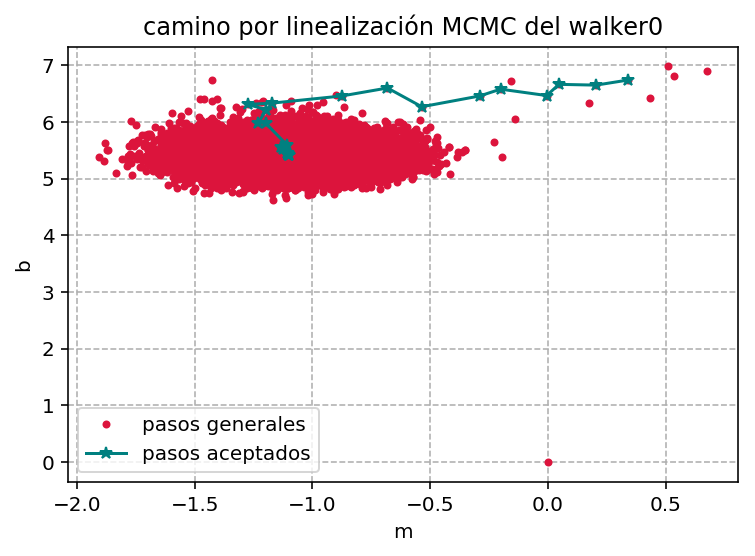

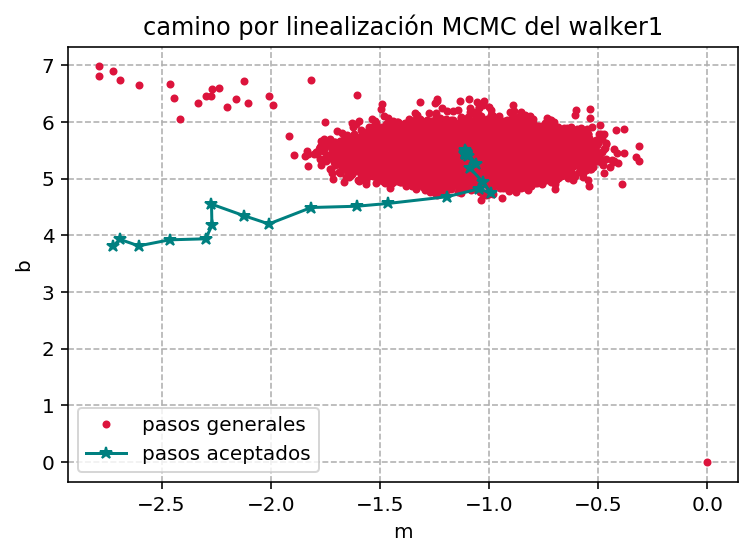

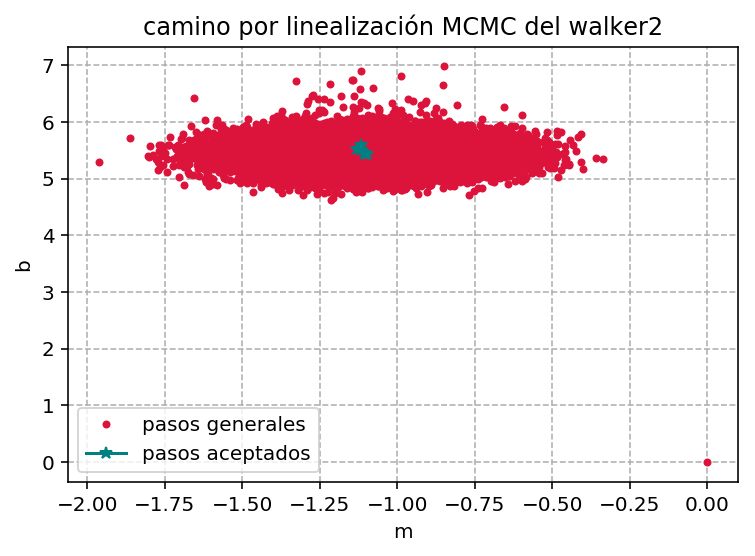

In [39]:
#walker[0][0][:,0] primer walker, matriz mb, con la primer entrada "m"
#walker[0][0][:,1] primer walker, matriz mb, con la segunda entrada "b"

#walkers[0][2] primer walker, mvector de b aceptados.

for i in range(caminadores):
    plt.plot(walkers[i][0][:,0],walkers[0][0][:,1],'.', color = 'crimson',label = 'pasos generales')
    plt.plot(walkers[i][1],walkers[i][2],'-*', color = 'teal',label = 'pasos aceptados')
    plt.legend()
    plt.title('camino por linealización MCMC del walker' + str(i))
    plt.xlabel('m')
    plt.ylabel('b')
    plt.grid(linestyle='--')
    plt.show()

In [12]:
# for i in range(caminadores):
#     plt.hist(walkers[i][1],5, color = 'indianred', label = 'm'+str(i))
#     plt.hist(walkers[i][2],5, color = 'tan', label = 'b'+str(i))
#     plt.title('Histogramas de $m$ y $b$ del caminador'+ str(i))
#     plt.legend()
#     plt.show()

In [13]:
# plt.plot(x,y,'o', label = 'data')
# plt.plot(x, (-0.9821623517930425)*x + 4.5778593037533595, label = 'linear regression')
# plt.title('plot approx by linear regression')
# plt.legend()
# plt.show()

# print('m approx by linear regression:',  -0.9821623517930425)
# print('b approx by linear regression:', 4.5778593037533595)
# #-----------------------------------------------------------------------------------
# # visualización de la linealización
# #-----------------------------------------------------------------------------------
# for i in range(caminadores):
#     plt.plot(x,y,'o', color='indianred', label = 'data')
#     plt.plot(x,f(x,walkers[i][1][-1],walkers[i][2][-1]), color = 'b',label = 'solution')
#     plt.title('linearization by MCMC of walker # ' + str(i))
#     plt.legend()
#     plt.show()

#     print('m approx by MCMC= ',walkers[i][1][-1])
#     print('b approx by MCMC= ',walkers[i][2][-1]) 



# German-Rubin diagnostic

# Convergencia de los parámetros m y b

In [14]:
def German_Rubin(caminadores,n_pasos,walkers):
    var_paramtr = np.zeros((caminadores,2)) #el 2 es por m y b
    avrg_param = np.zeros((caminadores,2))
    
    for i in range(caminadores):
        
        avrg_param[i] = np.array([np.mean(walkers[i][0][:,0]),np.mean(walkers[i][0][:,1])])
        
        var_paramtr[i,0] = np.var(walkers[i][0][:,0],ddof = 1)
        var_paramtr[i,1] = np.var(walkers[i][0][:,1],ddof = 1)
    
    if caminadores == 1:
        return 0
    else:
        s = [(np.square(var_paramtr[:,0]).sum())/caminadores, (np.square(var_paramtr[:,1]).sum())/caminadores]
        B_n = [(np.var(avrg_param[:,0], ddof = 1))/(caminadores - 1),(np.var(avrg_param[:,1], ddof = 1))/(caminadores - 1)]
        sigma =[(((n_pasos -1)*s[0])/n_pasos) + B_n[0], (((n_pasos -1)*s[1])/n_pasos) + B_n[1]]
        R = np.sqrt(np.divide(sigma,s))
        return R   

In [15]:
R = German_Rubin(caminadores,n_pasos,walkers)
#si R > 1 la solución puede converger
R

array([1.00212076, 1.02831372])

In [16]:
def German_Rubin1(caminadores,n_pasos,walkers):
    var_paramtr = np.zeros((caminadores,2)) #el 2 es por m y b
    avrg_param = np.zeros((caminadores,2))
    
    for i in range(caminadores):
        
        avrg_param[i] = np.array([np.mean(walkers[i][0][:,0]),np.mean(walkers[i][0][:,1])])
        
        var_paramtr[i,0] = np.var(walkers[i][0][:,0],ddof = 1)
        var_paramtr[i,1] = np.var(walkers[i][0][:,1],ddof = 1)
    
        s = [(np.square(var_paramtr[:,0]).sum())/caminadores, (np.square(var_paramtr[:,1]).sum())/caminadores]
        B_n = [(np.var(avrg_param[:,0], ddof = 1))/(caminadores - 1),(np.var(avrg_param[:,1], ddof = 1))/(caminadores - 1)]
        sigma =[(((n_pasos -1)*s[0])/n_pasos) + B_n[0], (((n_pasos -1)*s[1])/n_pasos) + B_n[1]]
        R = np.sqrt(np.divide(sigma,s))
        
        delta = np.random.rand()*10
    if 1<= np.all(R) and np.all(R) <= delta:
        print('la solución converge')
        return R
    else:
        print('La solución no converge')
        return 0

In [17]:
R1 = German_Rubin1(caminadores,n_pasos,walkers)
R1

la solución converge


array([1.00212076, 1.02831372])

# Gráficos triangulares

In [19]:
# Show plots inline, and load main getdist plot module and samples class
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
# use this *after* importing getdist if you want to use interactive plots
# %matplotlib notebook
import IPython
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True

GetDist Version: 1.1.2, Matplotlib version: 2.2.2


In [20]:
# Get some random samples for demonstration:
# make random covariance, then independent samples from Gaussian
ndim = caminadores*2
nsamp = n_pasos

np.random.seed(10)

A = np.random.rand(ndim,ndim)
cov = np.dot(A, A.T)
cov.fill(desv_estandar) #esto llena la matriz de covarianza

In [45]:
samps = walkers[0][0]
"""que disque agrega columnas"""
for i in range(1,caminadores):
    samps = np.c_[samps, walkers[i][0]]
    
#len(samps)
#samps

In [46]:
# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity
names = ["x%s"%i for i in range(ndim)]
labels =  ["x_%s"%i for i in range(ndim)]
samples = MCSamples(samples=samps,names = names, labels = labels)
#samples2 = MCSamples(samples=samps2,names = names, labels = labels, label='Second set')

Removed no burn in


C:\Users\Dea\Documents\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Dea\Documents\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Dea\Documents\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `a

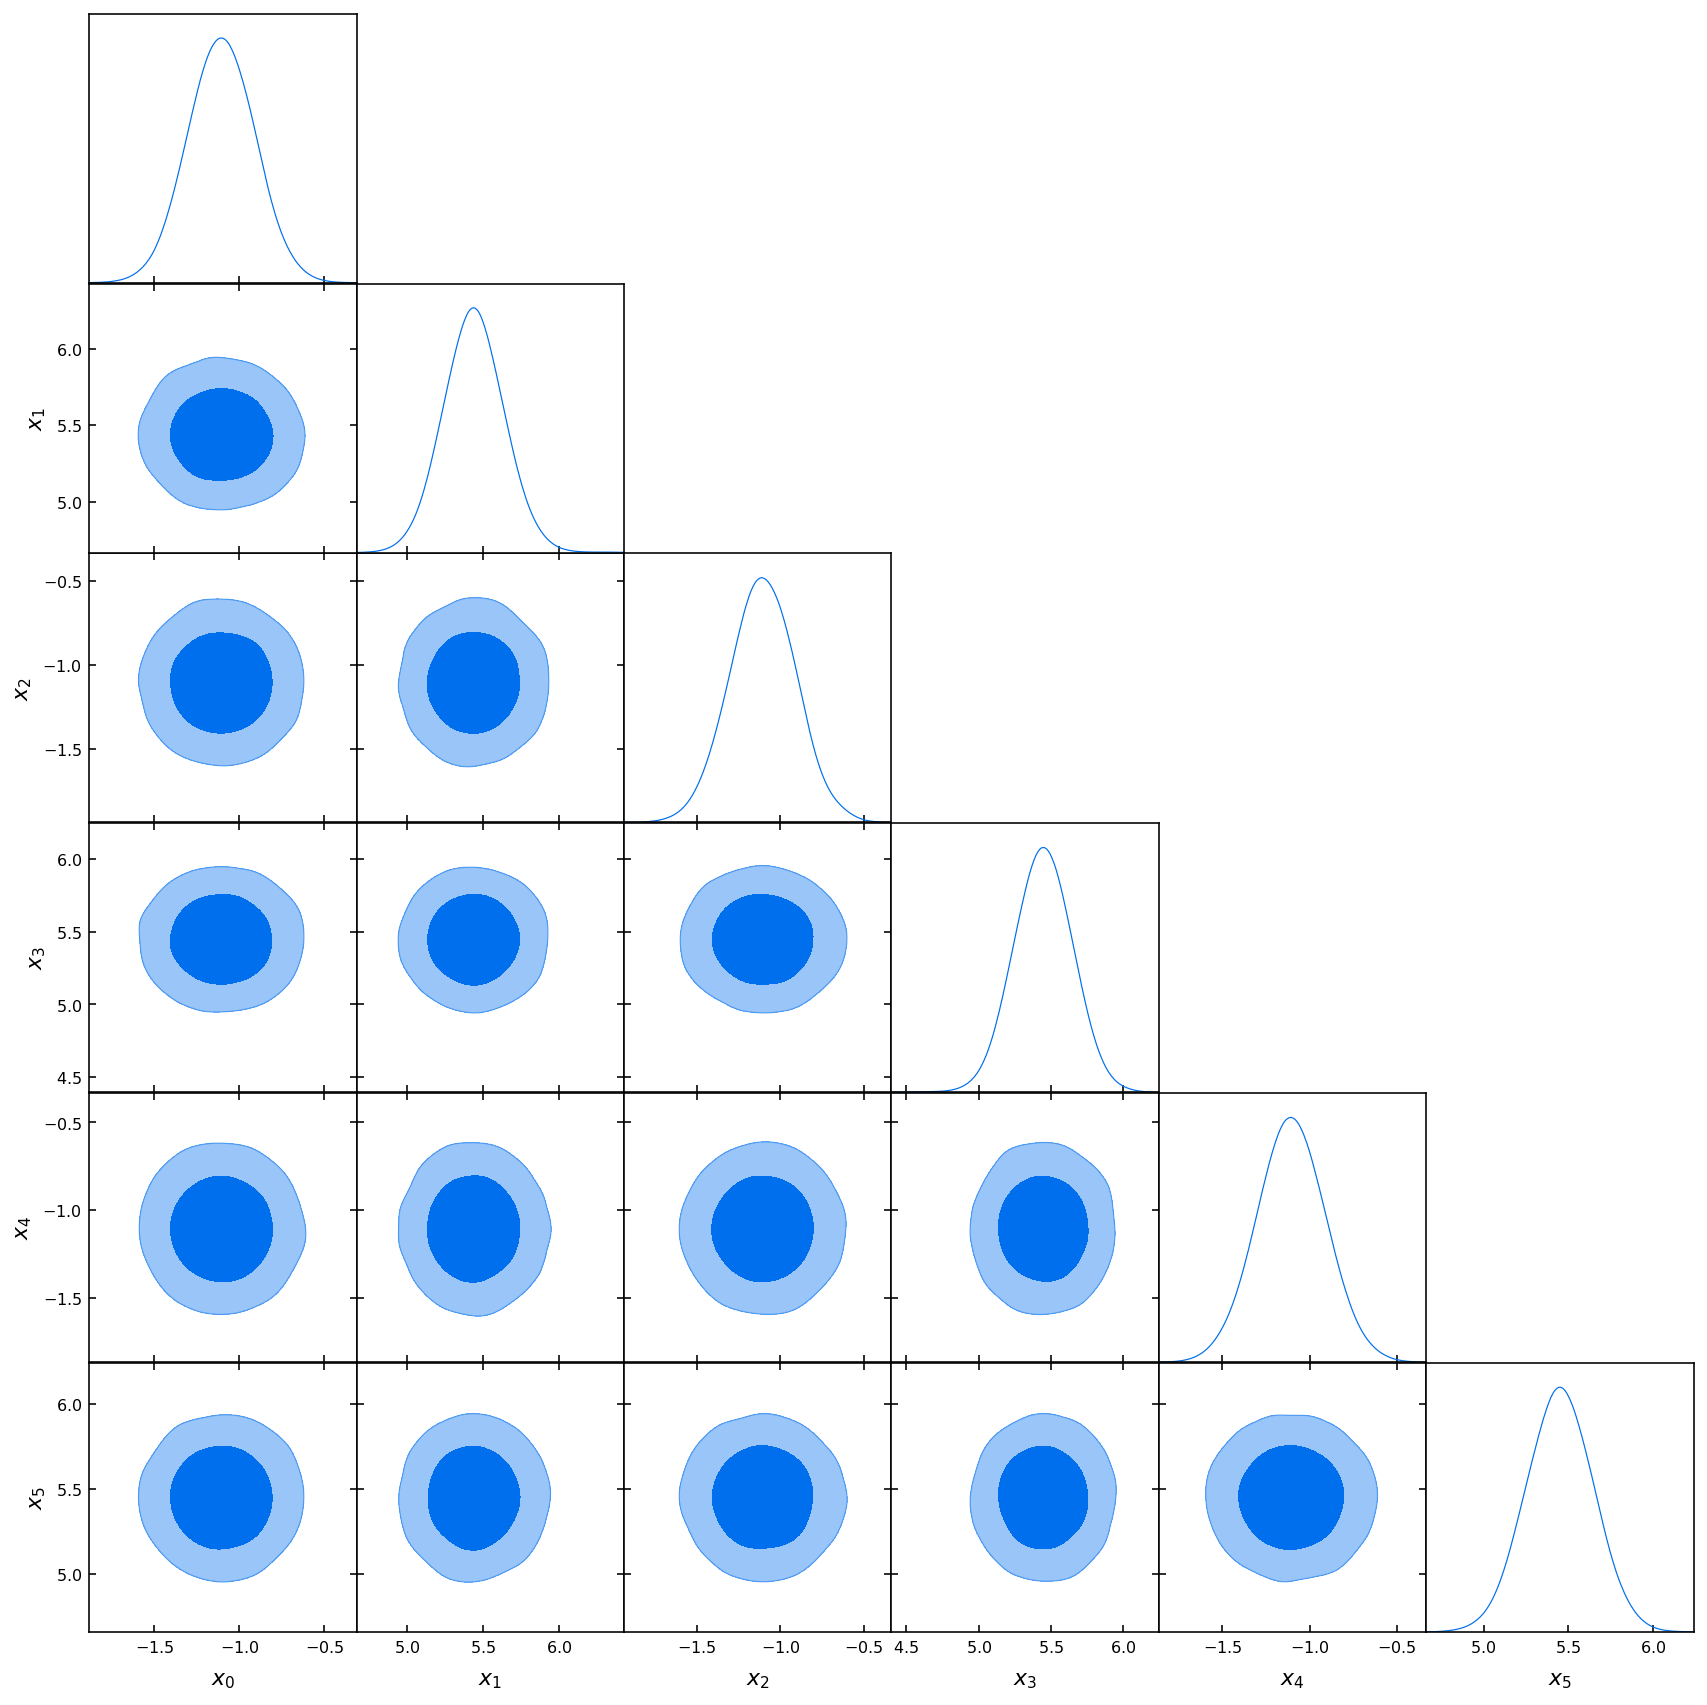

In [47]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled=True);

# Ddatos filtrados por metrópolis

In [92]:
samplesm = walkers[0][1][-5:]
samplesb = walkers[0][2][-5:]

for i in range(1,caminadores):
    samplesm = np.c_[samplesm, walkers[i][1][-5:]]
    
for i in range(1,caminadores):
    samplesb = np.c_[samplesb, walkers[i][2][-5:]]


In [102]:
# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity

names = ["x%s"%i for i in range(caminadores)]
labels =  ["x_%s"%i for i in range(caminadores)]

sampmAccpt = MCSamples(samples= samplesm ,names = names, labels = labels)

sampbAccpt = MCSamples(samples= samplesb ,names = names, labels = labels, label='Second set')

Removed no burn in
Removed no burn in


In [106]:
samplesm

array([[-1.10814904, -1.10747069, -1.11674099],
       [-1.09982714, -1.10432762, -1.0976244 ],
       [-1.1054866 , -1.10495941, -1.1059887 ],
       [-1.10486116, -1.10453874, -1.10596467],
       [-1.10300816, -1.10385652, -1.10357389]])

In [103]:
whos

Variable         Type                          Data/Info
--------------------------------------------------------
A                ndarray                       6x6: 36 elems, type `float64`, 288 bytes
Btot             ndarray                       30001x3: 90003 elems, type `float64`, 720024 bytes (703.1484375 kb)
German_Rubin     function                      <function German_Rubin at 0x000001E67708A9D8>
German_Rubin1    function                      <function German_Rubin1 at 0x000001E600F58378>
IPython          module                        <module 'IPython' from 'C<...>s\\IPython\\__init__.py'>
LogLikelihood    function                      <function LogLikelihood at 0x000001E677E9EB70>
MCSamples        type                          <class 'getdist.mcsamples.MCSamples'>
Mtot             ndarray                       30001x3: 90003 elems, type `float64`, 720024 bytes (703.1484375 kb)
Post             function                      <function Post at 0x000001E600F42E18>
Prior_b       

C:\Users\Dea\Documents\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


IndexError: index 1 is out of bounds for axis 0 with size 1

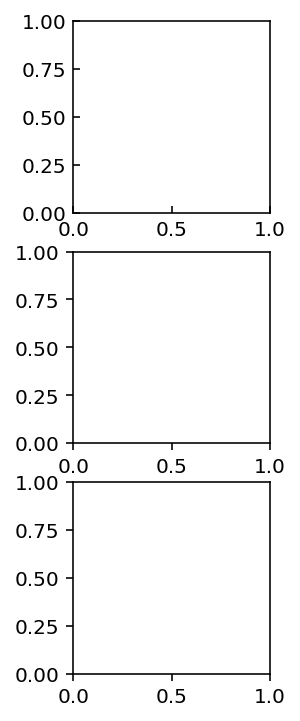

In [99]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([sampmAccpt,sampbAccpt], filled=True);

In [74]:
Mtot = walkers[0][0][:,0]
Btot = walkers[0][0][:,1]

"""que disque agrega columnas"""
for i in range(1,caminadores):
    Mtot = np.c_[Mtot, walkers[i][0][:,0]]
    
for i in range(1,caminadores):
    Btot = np.c_[Btot, walkers[i][0][:,1]]
    
#len(sampsBtot)
#samps

In [77]:
names = ["x%s"%i for i in range(caminadores)]
labels =  ["x_%s"%i for i in range(caminadores)]

samples1 = MCSamples(samples= Mtot ,names = names, labels = labels)
samples2 = MCSamples(samples= Btot ,names = names, labels = labels, label='Second set')


Removed no burn in
Removed no burn in


C:\Users\Dea\Documents\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Dea\Documents\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Dea\Documents\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `a

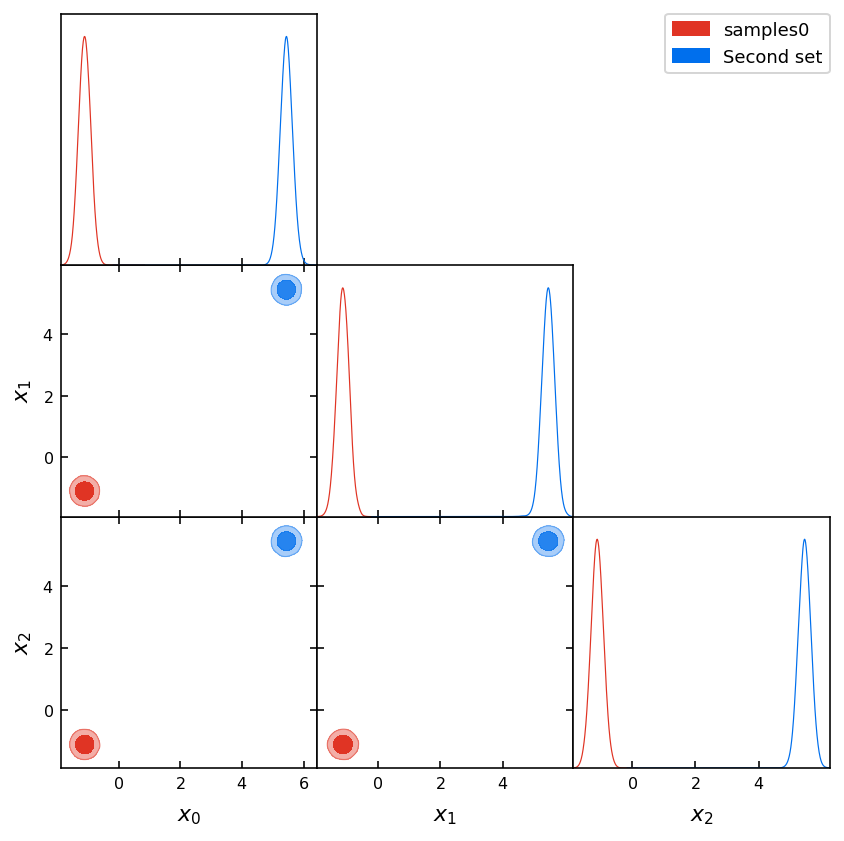

In [78]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples1, samples2], filled=True);

In [79]:
ndim

6